In [179]:
import pandas as pd
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchmetrics.classification import MulticlassF1Score
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split
from torchinfo import summary

In [180]:
trainDF=pd.read_csv('../0912/fasion_mnist_train.csv')
testDF=pd.read_csv('../0912/fasion_mnist_test.csv')

In [181]:
trainDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


In [182]:
trainDF.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [183]:
# 학습셋 타겟피쳐분리
train_target=trainDF[['label']]
train_feature=trainDF.drop(columns='label')
print(f'feauture {train_feature.shape}, target {train_target.shape}')

feauture (60000, 784), target (60000, 1)


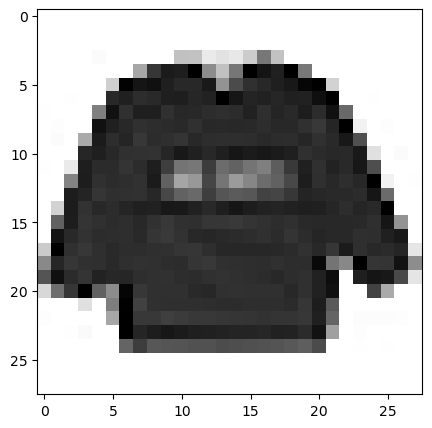

In [184]:
aa=train_feature.iloc[0].to_numpy().reshape(-1,28)
plt.figure(figsize=(5,5))
plt.imshow(aa,cmap='binary')

In [185]:
testDF

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,32,23,14,20,0,0,1,0,0,0
9996,6,0,0,0,0,0,0,0,0,0,...,0,0,0,2,52,23,28,0,0,0
9997,8,0,0,0,0,0,0,0,0,0,...,175,172,172,182,199,222,42,0,1,0
9998,8,0,1,3,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [186]:
# 테스트셋 타겟피쳐분리
test_target=testDF[['label']]
test_feature=testDF.drop(columns='label')
print(f'feauture {test_feature.shape}, target {test_target.shape}')

feauture (10000, 784), target (10000, 1)


In [187]:
## 데이터셋 클래스 생성
class FasionDataSet(Dataset):
    
    def __init__(self,feature,target):
        super().__init__()
        self.feature=feature
        self.target=target
        self.n_rows=feature.shape[0]
        self_n_features=feature.shape[1]

    def __len__(self):
        return self.n_rows

    def __getitem__(self, index):
        featureTS=torch.FloatTensor(self.feature.iloc[index].values)
        targetTS=torch.FloatTensor(self.target.iloc[index].values)
        return featureTS,targetTS



In [188]:
# 학습셋 검증셋 분리
X_train,X_val,y_train,y_val=train_test_split(train_feature,train_target)

In [189]:
print(f'Train set',X_train.shape,y_train.shape)
print('Val set',X_val.shape,y_val.shape)

Train set (45000, 784) (45000, 1)
Val set (15000, 784) (15000, 1)


In [190]:
# 데이터셋 준비
trainDS=FasionDataSet(X_train,y_train)
valDS=FasionDataSet(X_val,y_val)
testDS=FasionDataSet(test_feature,test_target)

In [191]:
feature_num=len(train_target.value_counts())

In [192]:
# 모델 클래스 생성
class FasionModel(nn.Module):

    def __init__(self,feature_n,target_n,num_list=[]):
        super().__init__()
        self.in_layer=nn.Linear(feature_n,num_list[0] if len(num_list) else 5)
        self.h_layer=nn.ModuleList()
        for num in range(len(num_list)-1):
            self.h_layer.append(nn.Linear(num_list[num],num_list[num+1]))
        self.out_layer=nn.Linear(num_list[-1] if len(num_list) else 5,feature_num)


    def forward(self,X):
        X=F.relu(self.in_layer(X))
        for model in self.h_layer:
            X=F.relu(model(X))
        return self.out_layer(X)


In [193]:
model=FasionModel(train_feature.shape[1],train_target.shape[1],num_list=[10000])

In [194]:
# 모델 확인인
summary(model,input_size=(45000,784))

Layer (type:depth-idx)                   Output Shape              Param #
FasionModel                              [45000, 10]               --
├─Linear: 1-1                            [45000, 10000]            7,850,000
├─Linear: 1-2                            [45000, 10]               100,010
Total params: 7,950,010
Trainable params: 7,950,010
Non-trainable params: 0
Total mult-adds (G): 357.75
Input size (MB): 141.12
Forward/backward pass size (MB): 3603.60
Params size (MB): 31.80
Estimated Total Size (MB): 3776.52

In [195]:
EPOCH=35
BATCH_SIZE=20000
loss_fun=nn.CrossEntropyLoss()
score_fun=MulticlassF1Score(num_classes=feature_num)

In [196]:
optimizer=optim.Adam(model.parameters(),lr=0.003)

In [197]:
fasionDL=DataLoader(trainDS,batch_size=BATCH_SIZE)

val_featureTS=torch.FloatTensor(valDS.feature.values)
val_targetTS=torch.FloatTensor(valDS.target.values)

In [198]:
def fasion_train(fasionDL,valDS,EPOCH):
    loss_score_dict={'loss':[[],[]],'score':[[],[]]}

    for epoch in range(EPOCH):
        # 학습모드
        model.train()

        total_loss=0
        total_score=0
        for feature,target in fasionDL:
            pre_y=model(feature)

            loss=loss_fun(pre_y,target.reshape(-1).long())
            total_loss+=loss.item()
            
            score=score_fun(pre_y,target.reshape(-1))
            total_score+=score.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_score_dict['loss'][0].append(total_loss/len(fasionDL))
        loss_score_dict['score'][0].append(total_score/len(fasionDL))

        #검증모드
        model.eval()
        
        val_pre_y=model(val_featureTS)

        loss=loss_fun(val_pre_y,val_targetTS.reshape(-1).long())
        score=score_fun(val_pre_y,val_targetTS.reshape(-1))

        loss_score_dict['loss'][1].append(loss.item())
        loss_score_dict['score'][1].append(score.item())
        print(f'[{epoch+1}/{EPOCH}]')
        print(f'train loss: {loss_score_dict["loss"][0][-1]} val loss: {loss_score_dict["loss"][1][-1]}')
        print(f'train score: {loss_score_dict["score"][0][-1]} val score: {loss_score_dict["score"][1][-1]}')
    
    return loss_score_dict

            

In [199]:
loss_score_dict=fasion_train(fasionDL,valDS,EPOCH)

[1/35]
train loss: 1461.2537854512532 val loss: 2887.51806640625
train score: 0.1496434286236763 val score: 0.08123456686735153
[2/35]
train loss: 1734.422098795573 val loss: 378.66302490234375
train score: 0.10604458302259445 val score: 0.30533427000045776
[3/35]
train loss: 239.03168233235678 val loss: 52.8906364440918
train score: 0.30389103293418884 val score: 0.39990729093551636
[4/35]
train loss: 39.0865421295166 val loss: 25.377004623413086
train score: 0.4494416117668152 val score: 0.4577605128288269
[5/35]
train loss: 18.05405902862549 val loss: 8.96215534210205
train score: 0.5077686111132304 val score: 0.5982596278190613
[6/35]
train loss: 6.461172580718994 val loss: 4.105886936187744
train score: 0.651102880636851 val score: 0.6792005300521851
[7/35]
train loss: 3.4570817152659097 val loss: 2.6533496379852295
train score: 0.70287557442983 val score: 0.7181726098060608
[8/35]
train loss: 2.3037715752919516 val loss: 1.8508684635162354
train score: 0.711774468421936 val score

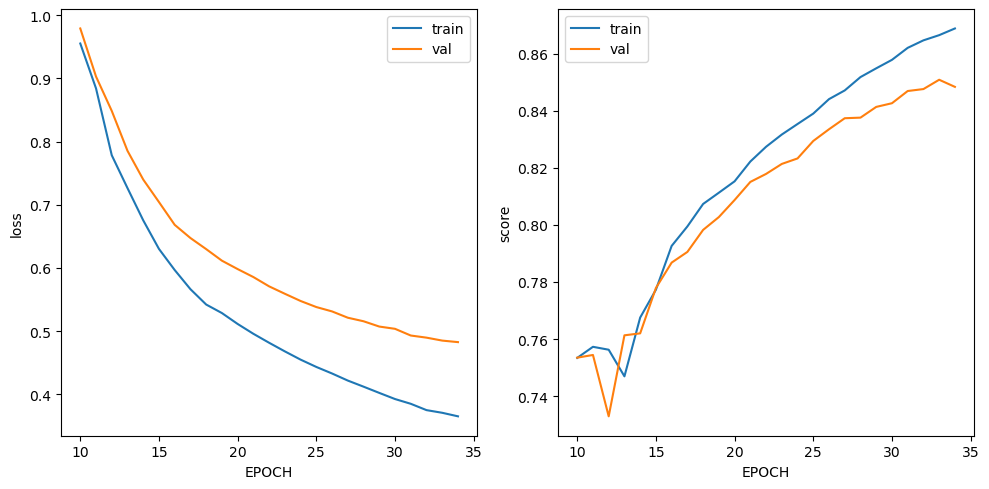

In [200]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
plotnum=25
ax[0].plot(range(EPOCH-plotnum,EPOCH),loss_score_dict['loss'][0][-1*plotnum:],label='train')
ax[0].plot(range(EPOCH-plotnum,EPOCH),loss_score_dict['loss'][1][-1*plotnum:],label='val')
ax[0].set(xlabel='EPOCH',ylabel='loss')
ax[0].legend()

ax[1].plot(range(EPOCH-plotnum,EPOCH),loss_score_dict['score'][0][-1*plotnum:],label='train')
ax[1].plot(range(EPOCH-plotnum,EPOCH),loss_score_dict['score'][1][-1*plotnum:],label='val')
ax[1].set(xlabel='EPOCH',ylabel='score')
ax[1].legend()

plt.tight_layout()
plt.show()

In [201]:
# 테스트 데이터 확인

test_feature=torch.FloatTensor(testDS.feature.values)
test_target=torch.FloatTensor(testDS.target.values)

pre_y=model(test_feature)
test_loss=loss_fun(pre_y,test_target.reshape(-1).long())
test_score=score_fun(pre_y,test_target.reshape(-1))

print(f'[Test] loss {test_loss} score {test_score}')

[Test] loss 0.4726271629333496 score 0.8493432998657227
